# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr28.pkl", "rb") as file:
    genes_dict28 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
cs_genes = genes_dict28['chimp']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_cs = df[cs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


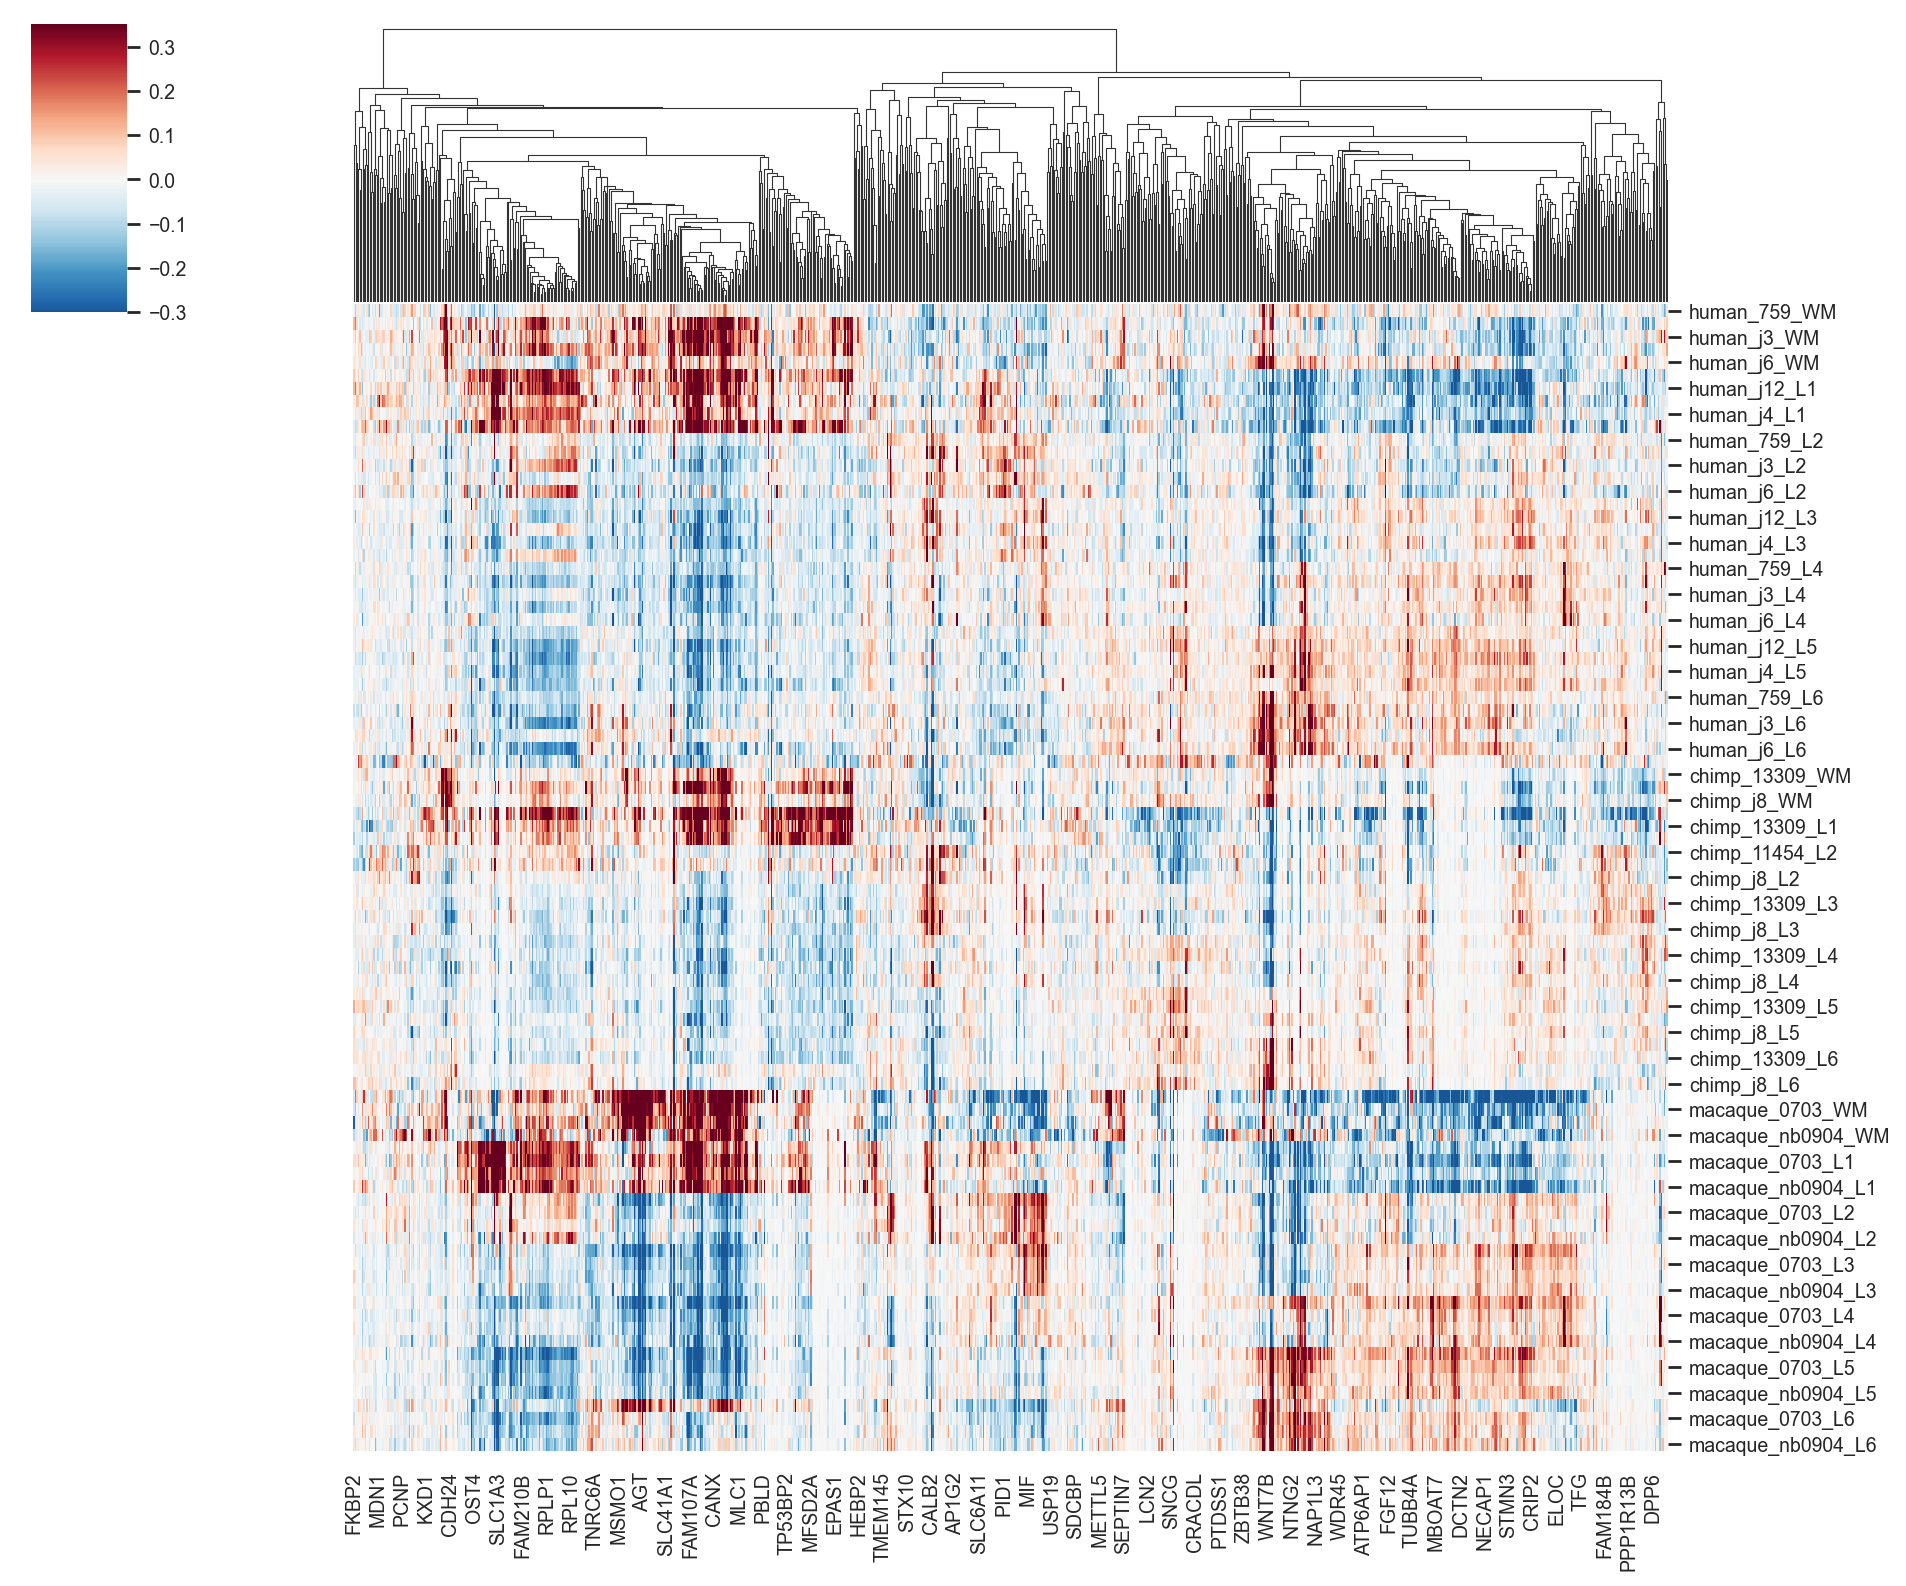

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_cs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.35, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [71]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_cs.loc[sample_order['chimp']].T, metric='cosine') + 1
n_clusters = 2
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=2,
                   random_state=4)

In [72]:
labels = pd.Series(clustering.labels_, index=cs_genes).sort_values()
order = labels.sort_values().index

In [73]:
labels.to_csv('./results/chimp_clusters_28.csv')

<Axes: >

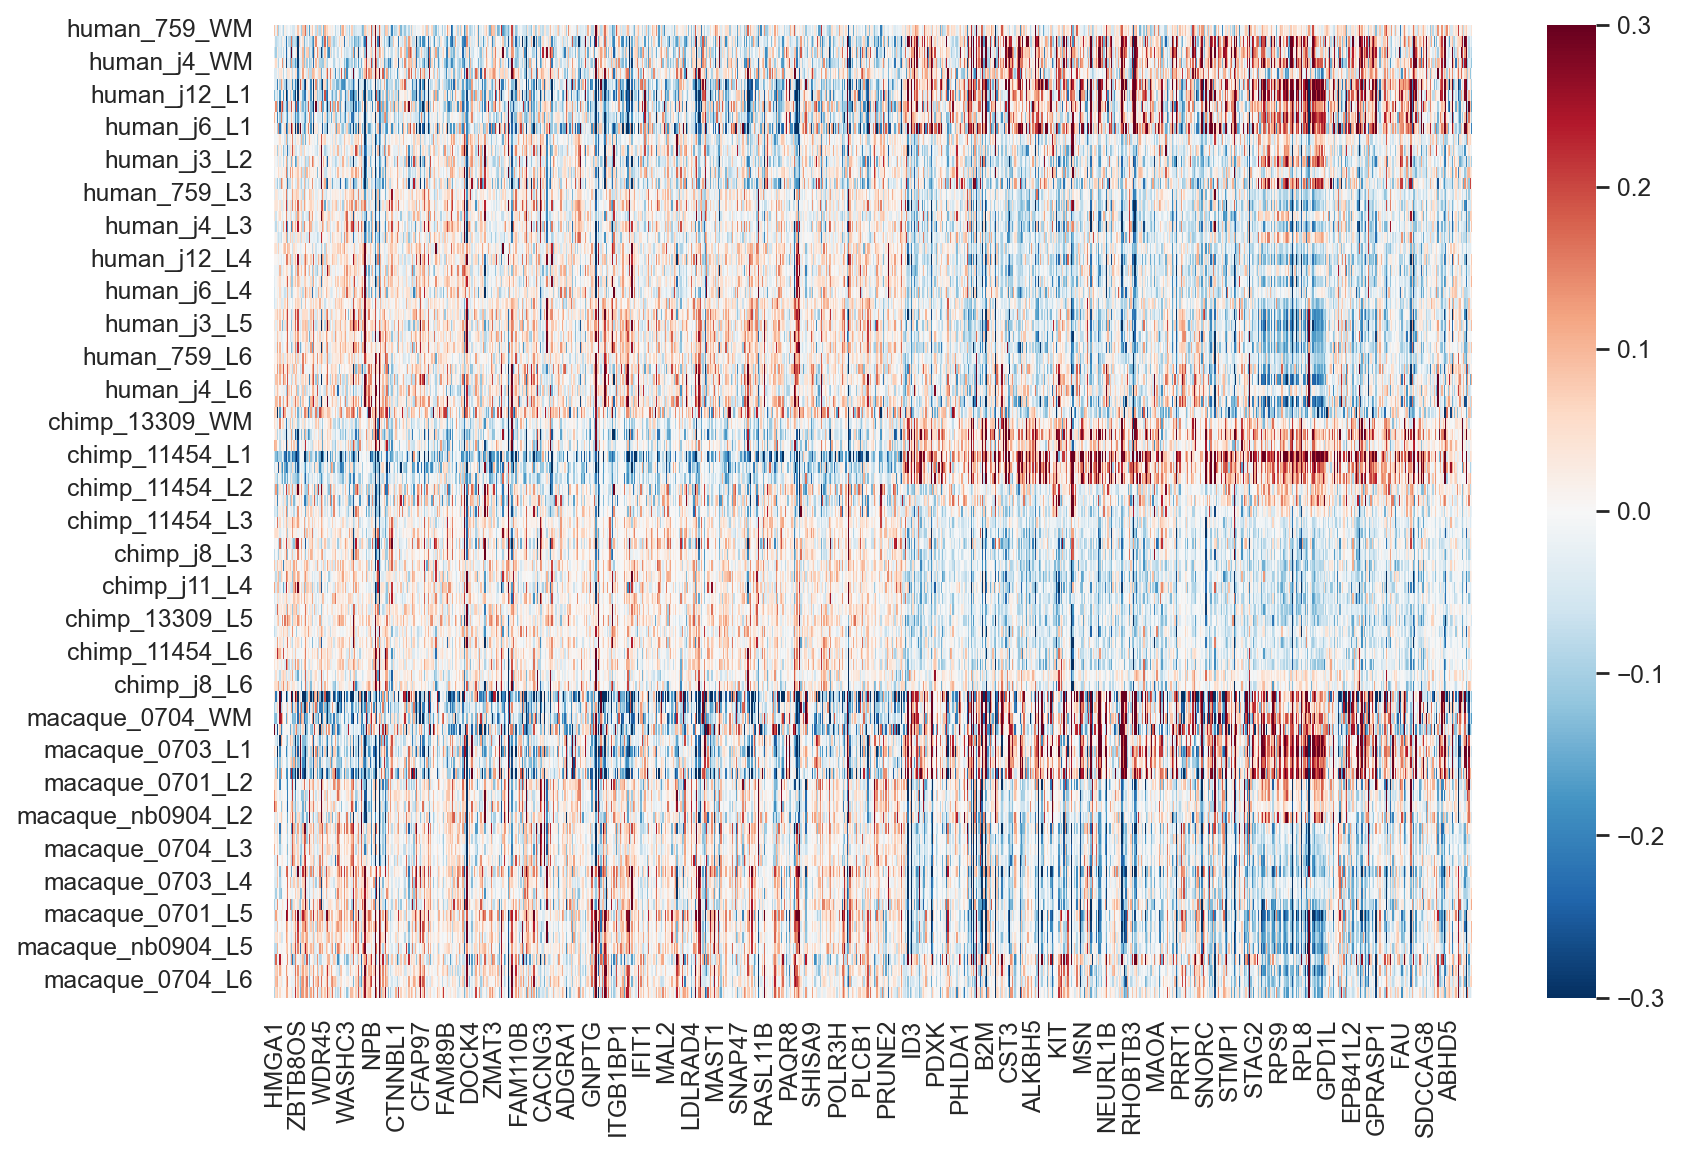

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_cs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

## Cluster profiles

In [75]:
df_annotation = df_cs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [76]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABHD5    ABI3BP    ABLIM3      ACHE    ACTL6B     ACTN2  \
condition layer                                                               
chimp     L1     0.127274 -0.001889  0.080621  0.018012 -0.001000 -0.037919   
          L2    -0.021975 -0.072809  0.058166  0.025632 -0.001000  0.125905   
          L3     0.018473 -0.030131 -0.071924  0.032533 -0.000865  0.220166   
          L4    -0.006185 -0.048345 -0.042444 -0.018455 -0.002231  0.011400   
          L5    -0.042524 -0.033888  0.013016 -0.021038  0.000056 -0.084475   

                   ACTR1A    ADAM19    ADAM23  ADCYAP1R1  ...   ZFP36L1  \
condition layer                                           ...             
chimp     L1    -0.031114 -0.102926 -0.166651  -0.001043  ...  0.334852   
          L2    -0.063103 -0.052312 -0.058098  -0.001043  ... -0.105753   
          L3     0.023699  0.022697  0.001673   0.001164  ... -0.228189   
          L4     0.066424  0.011080 -0.015478   0.001704  ... -0.208757   
          L5     0.010913  0.082050  0.011672   0.000260  ... -0.175580   

                    ZFPL1     ZMAT3    ZNF292    ZNF358    ZNF536    ZNF697  \
condition layer                                                               
chimp     L1     0.109823  0.000000 -0.044417  0.139470  0.148300 -0.094069   
          L2     0.000553  0.000000  0.032054  0.021451  0.147031 -0.031778   
          L3     0.022311  0.001719 -0.047701  0.010267 -0.015031 -0.001920   
          L4    -0.056616 -0.001343 -0.043522 -0.019590 -0.007308  0.076325   
          L5    -0.005033 -0.000197 -0.018067 -0.044868 -0.033428  0.015786   

                    ZNF74    ZNF771    ZWILCH  
condition layer                                
chimp     L1    -0.044226  0.103981  0.002993  
          L2     0.108836 -0.042995  0.003258  
          L3     0.000388  0.032819 -0.002625  
          L4    -0.032636 -0.024613  0.004127  
          L5    -0.032035 -0.023965 -0.012560  

[5 rows x 929 columns]

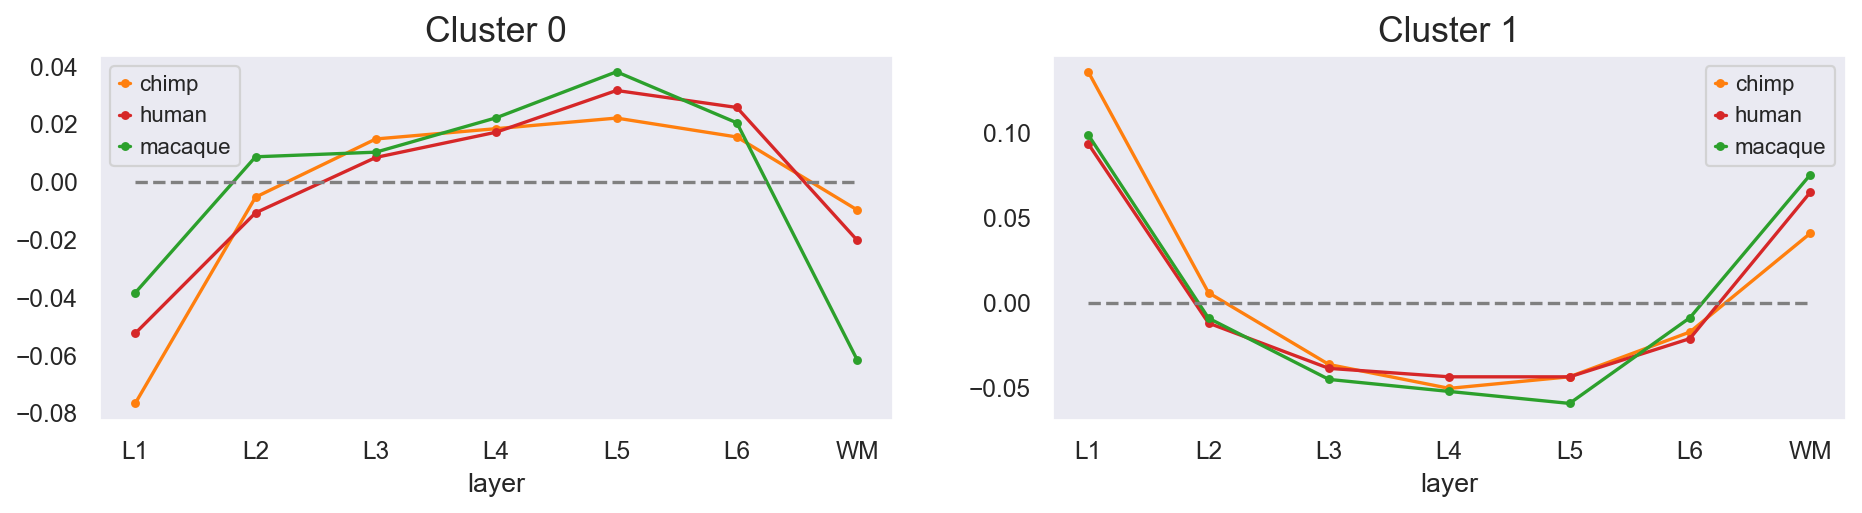

In [77]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [26]:
anova_cs_inter = cs_genes.intersection(anova_labels.index)
anova_cs_inter

Index(['ABI3BP', 'ABLIM3', 'ACTL6B', 'ACTN2', 'ACTR1A', 'ADAM19', 'ADAM23',
       'ADCYAP1R1', 'ADD3', 'ADGRA1',
       ...
       'ZBTB38', 'ZBTB47', 'ZBTB8OS', 'ZFAND3', 'ZFPL1', 'ZMAT3', 'ZNF536',
       'ZNF697', 'ZNF771', 'ZWILCH'],
      dtype='object', length=704)

In [27]:
table_to_pivot = pd.concat([anova_labels.loc[anova_cs_inter], labels.loc[anova_cs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'cs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

cs_labels,0,1,2
ANOVA_labels,,,
0,12,38,12
1,90,21,22
2,16,29,8
3,15,19,40
4,75,51,27
5,30,50,15
6,3,6,125


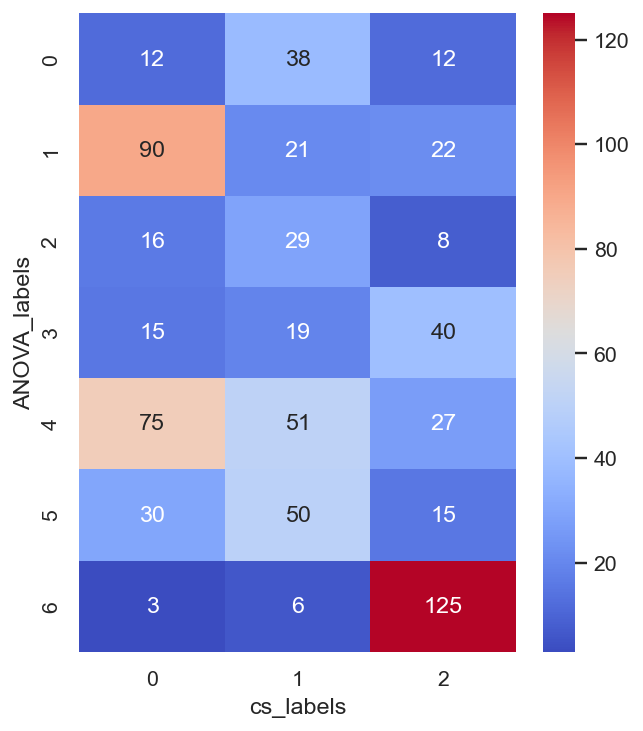

In [28]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

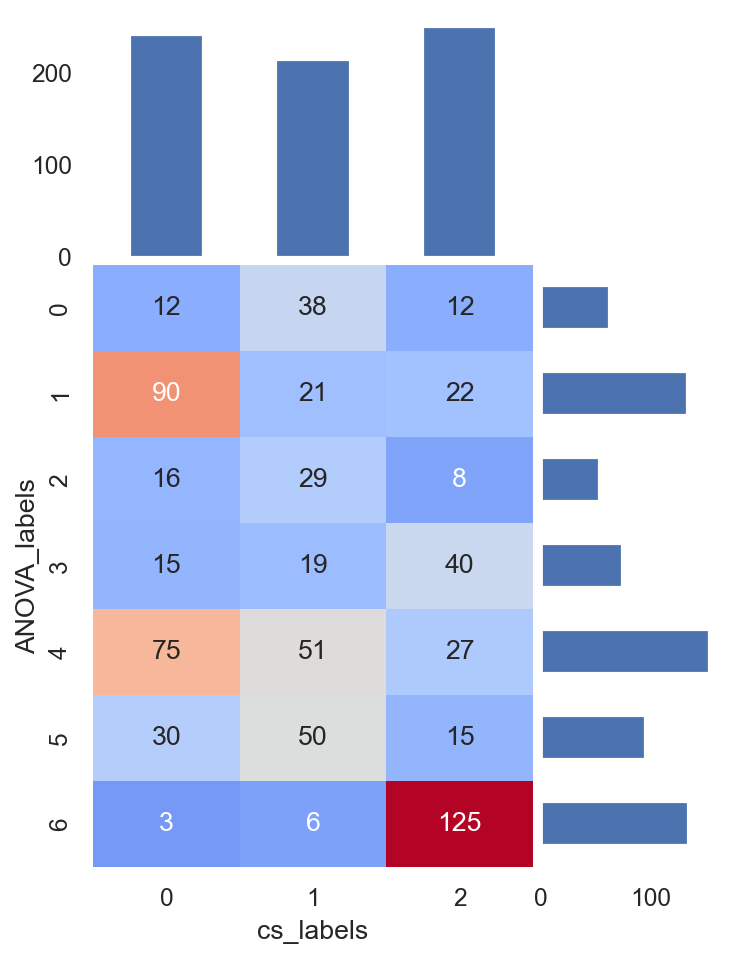

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=50, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Intersection with clusters of 0.77 threashold

In [57]:
with open("./results/specie_specific_genes_tr77.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

In [66]:
chimp_77_labels = pd.read_csv('./results/chimp_clusters_77.csv', index_col=0)['0'].sort_values()
chimp_77_labels.name = 'chimp_77_labels'

In [59]:
thr_cs_inter = cs_genes.intersection(genes_dict77['chimp'])
thr_cs_inter

Index(['ACTN2', 'AGT', 'B3GALT2', 'CALB2', 'CBLN2', 'CELF4', 'CLEC3B', 'CRYAB',
       'CXCL14', 'CYP26A1', 'DYNC1I1', 'EPHA3', 'ETV1', 'GLUL', 'GRIA4', 'ID1',
       'ID3', 'IGFBP5', 'ITM2A', 'MASP1', 'MCUB', 'MLC1', 'MOAP1', 'NELL1',
       'NEUROD6', 'NFIA', 'NPTX1', 'NR4A2', 'QKI', 'RASL11B', 'RELN', 'RPRM',
       'SLC1A2', 'SNORC', 'SPARC', 'SPON1', 'SPP1', 'SST', 'SULF1', 'SV2B',
       'THBS1', 'TIMP3', 'TSC22D4', 'WASF1'],
      dtype='object')

In [68]:
table_to_pivot = pd.concat([chimp_77_labels.loc[thr_cs_inter], labels.loc[thr_cs_inter]], axis=1)
table_to_pivot.columns = ['chimp_77_labels', 'chimp_28_labels']
pivot_labels_inter = table_to_pivot.groupby('chimp_77_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

chimp_28_labels,0,1,2
chimp_77_labels,,,
0,15.0,1.0,3.0
1,0.0,9.0,16.0


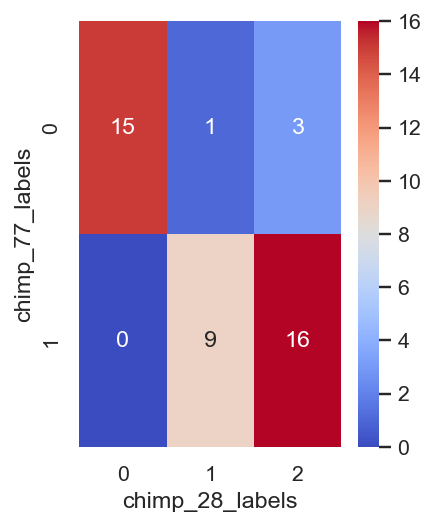

In [70]:
plt.figure(figsize=(3, 4), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

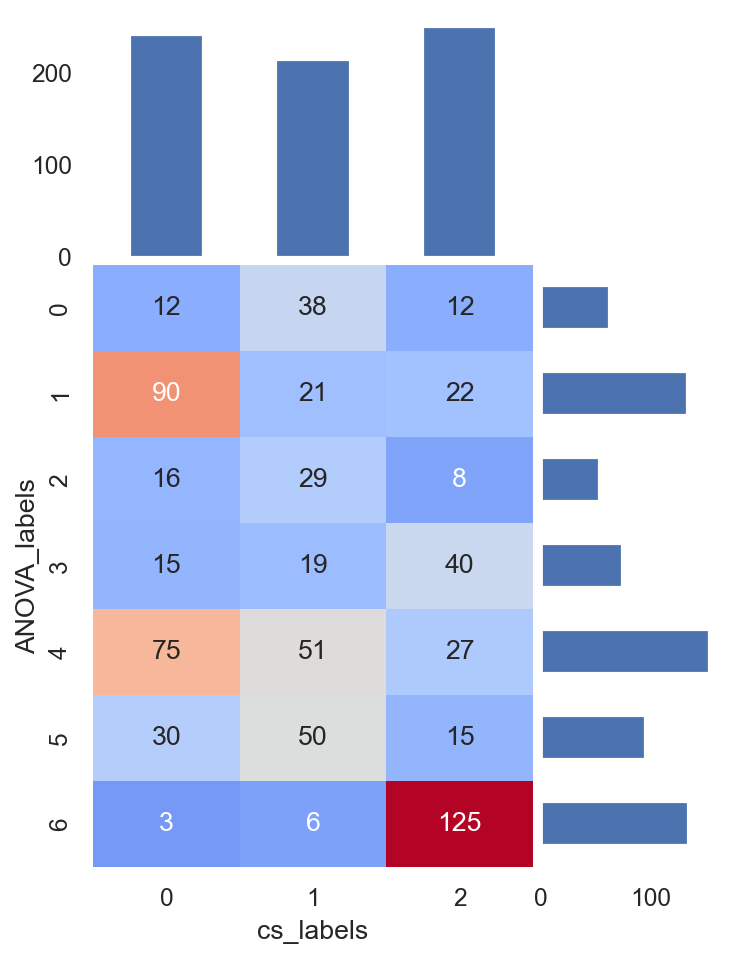

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=50, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [30]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/3 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [31]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [32]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
anterograde trans-synaptic signaling (GO:0098916),1,0.000074,3.548970,33.744882,"[GABRA1, SLC1A1, GRIK1, HTR2A, GABRG1, AKAP9, ...",0.142222,0,0,15,0.847033,0
transmembrane receptor protein tyrosine kinase signaling pathway (GO:0007169),2,0.000241,2.717055,22.637036,"[CYFIP2, RBFOX2, ATP6AP1, NRG1, PTPN11, PIK3R1...",0.230706,0,0,19,0.636942,0
presynaptic endocytosis (GO:0140238),3,0.000409,9.807947,76.516416,"[SYNJ1, SNCG, AMPH, SNCB, SNCA]",0.241146,0,0,5,0.617721,0
chemical synaptic transmission (GO:0007268),4,0.000503,2.807018,21.316646,"[GABRA1, SLC1A1, GRIK1, HTR2A, GABRG1, AKAP9, ...",0.241146,0,0,16,0.617721,0
synaptic vesicle recycling (GO:0036465),5,0.001005,7.739631,53.422665,"[SYNJ1, SNCG, AMPH, SNCB, SNCA]",0.385226,0,0,5,0.414285,0


In [33]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

10

In [34]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

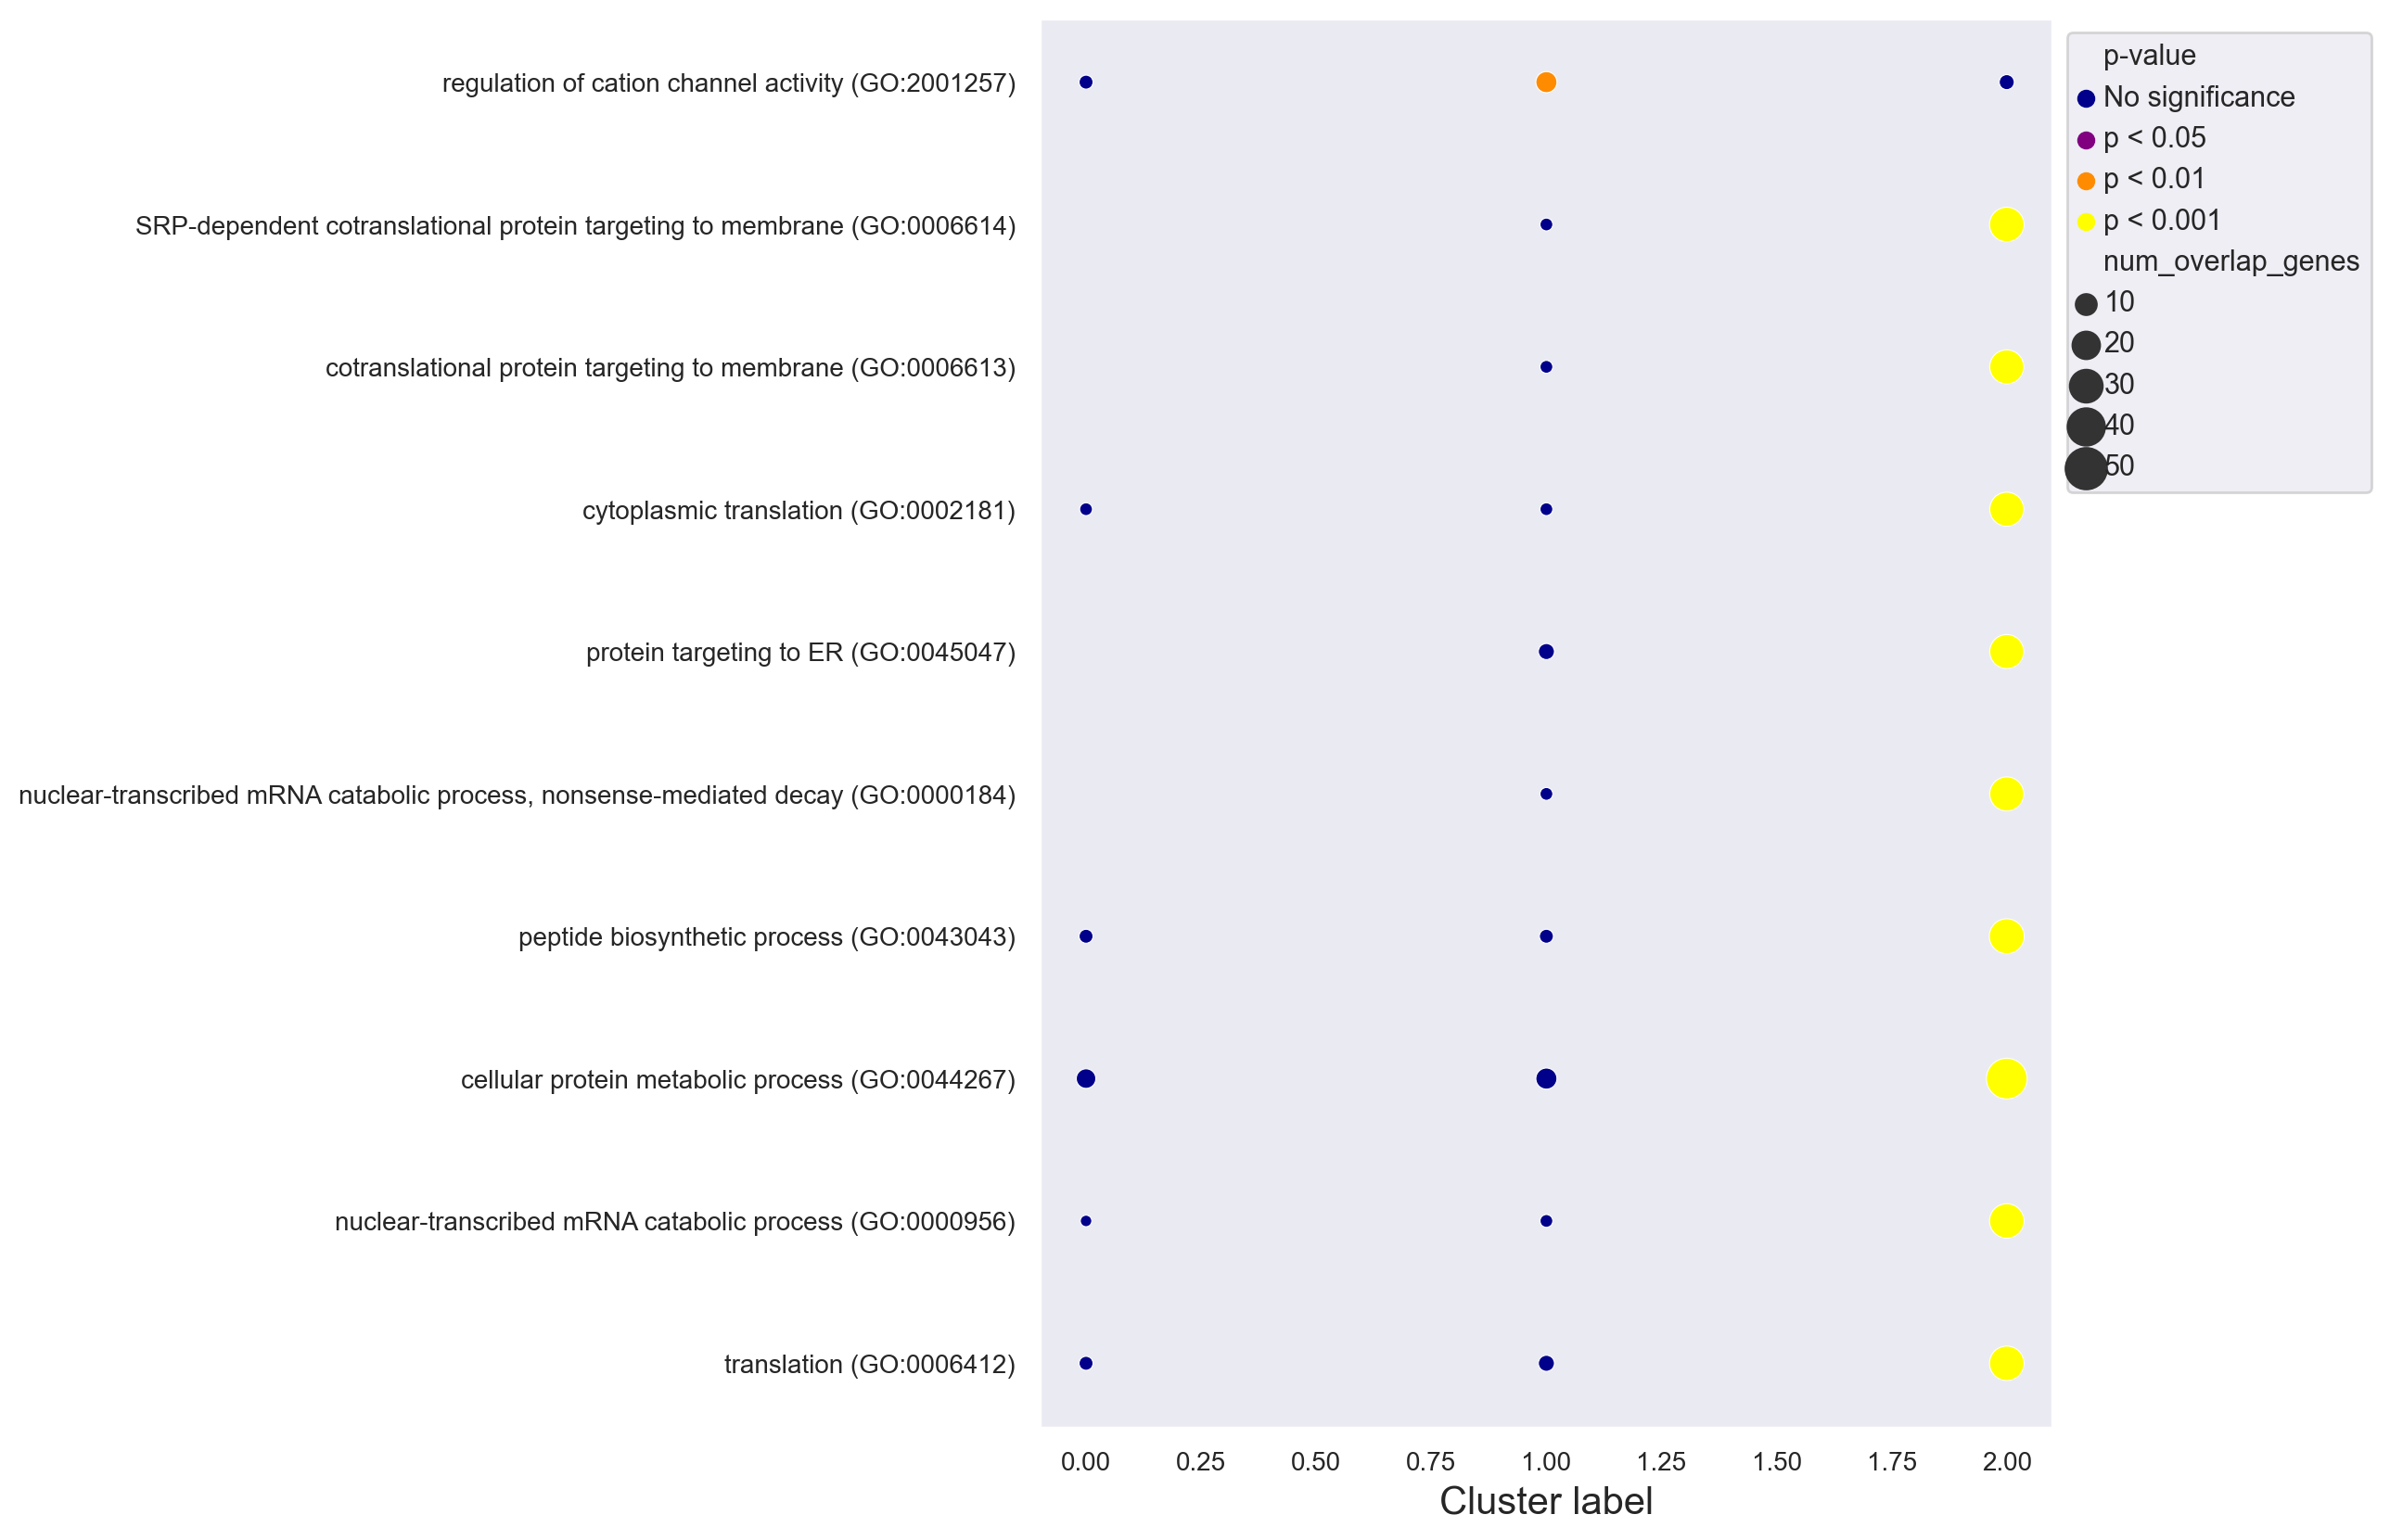

In [35]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [36]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [37]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
FEZF2+ CFTR+ Layer 5-6 Glutamatergic Neuron CL0000679,1,0.001108,inf,inf,"[NR4A2, FEZF2]",0.057452,0,0,2,1.240698,0
Neuroendocrine CL0000165,2,0.001814,17.557895,110.826777,"[EGR1, CPE, SEC11C]",0.057452,0,0,3,1.240698,0
PVALB+ SAMD13+ Layer 3 GABAergic Neuron CL0000617,3,0.001814,17.557895,110.826777,"[SULF1, TAC1, EPHA3]",0.057452,0,0,3,1.240698,0
FEZF2+ POGK+ Layer 6 Glutamatergic Neuron CL0000679,4,0.006358,29.177049,147.576790,"[MGAT4C, FEZF2]",0.082053,0,0,2,1.085905,0
FEZF2+ RNF144A-AS1+ Layer 5 Glutamatergic Neuron CL0000679,5,0.006358,29.177049,147.576790,"[GRIK1, FEZF2]",0.082053,0,0,2,1.085905,0


In [38]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [39]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

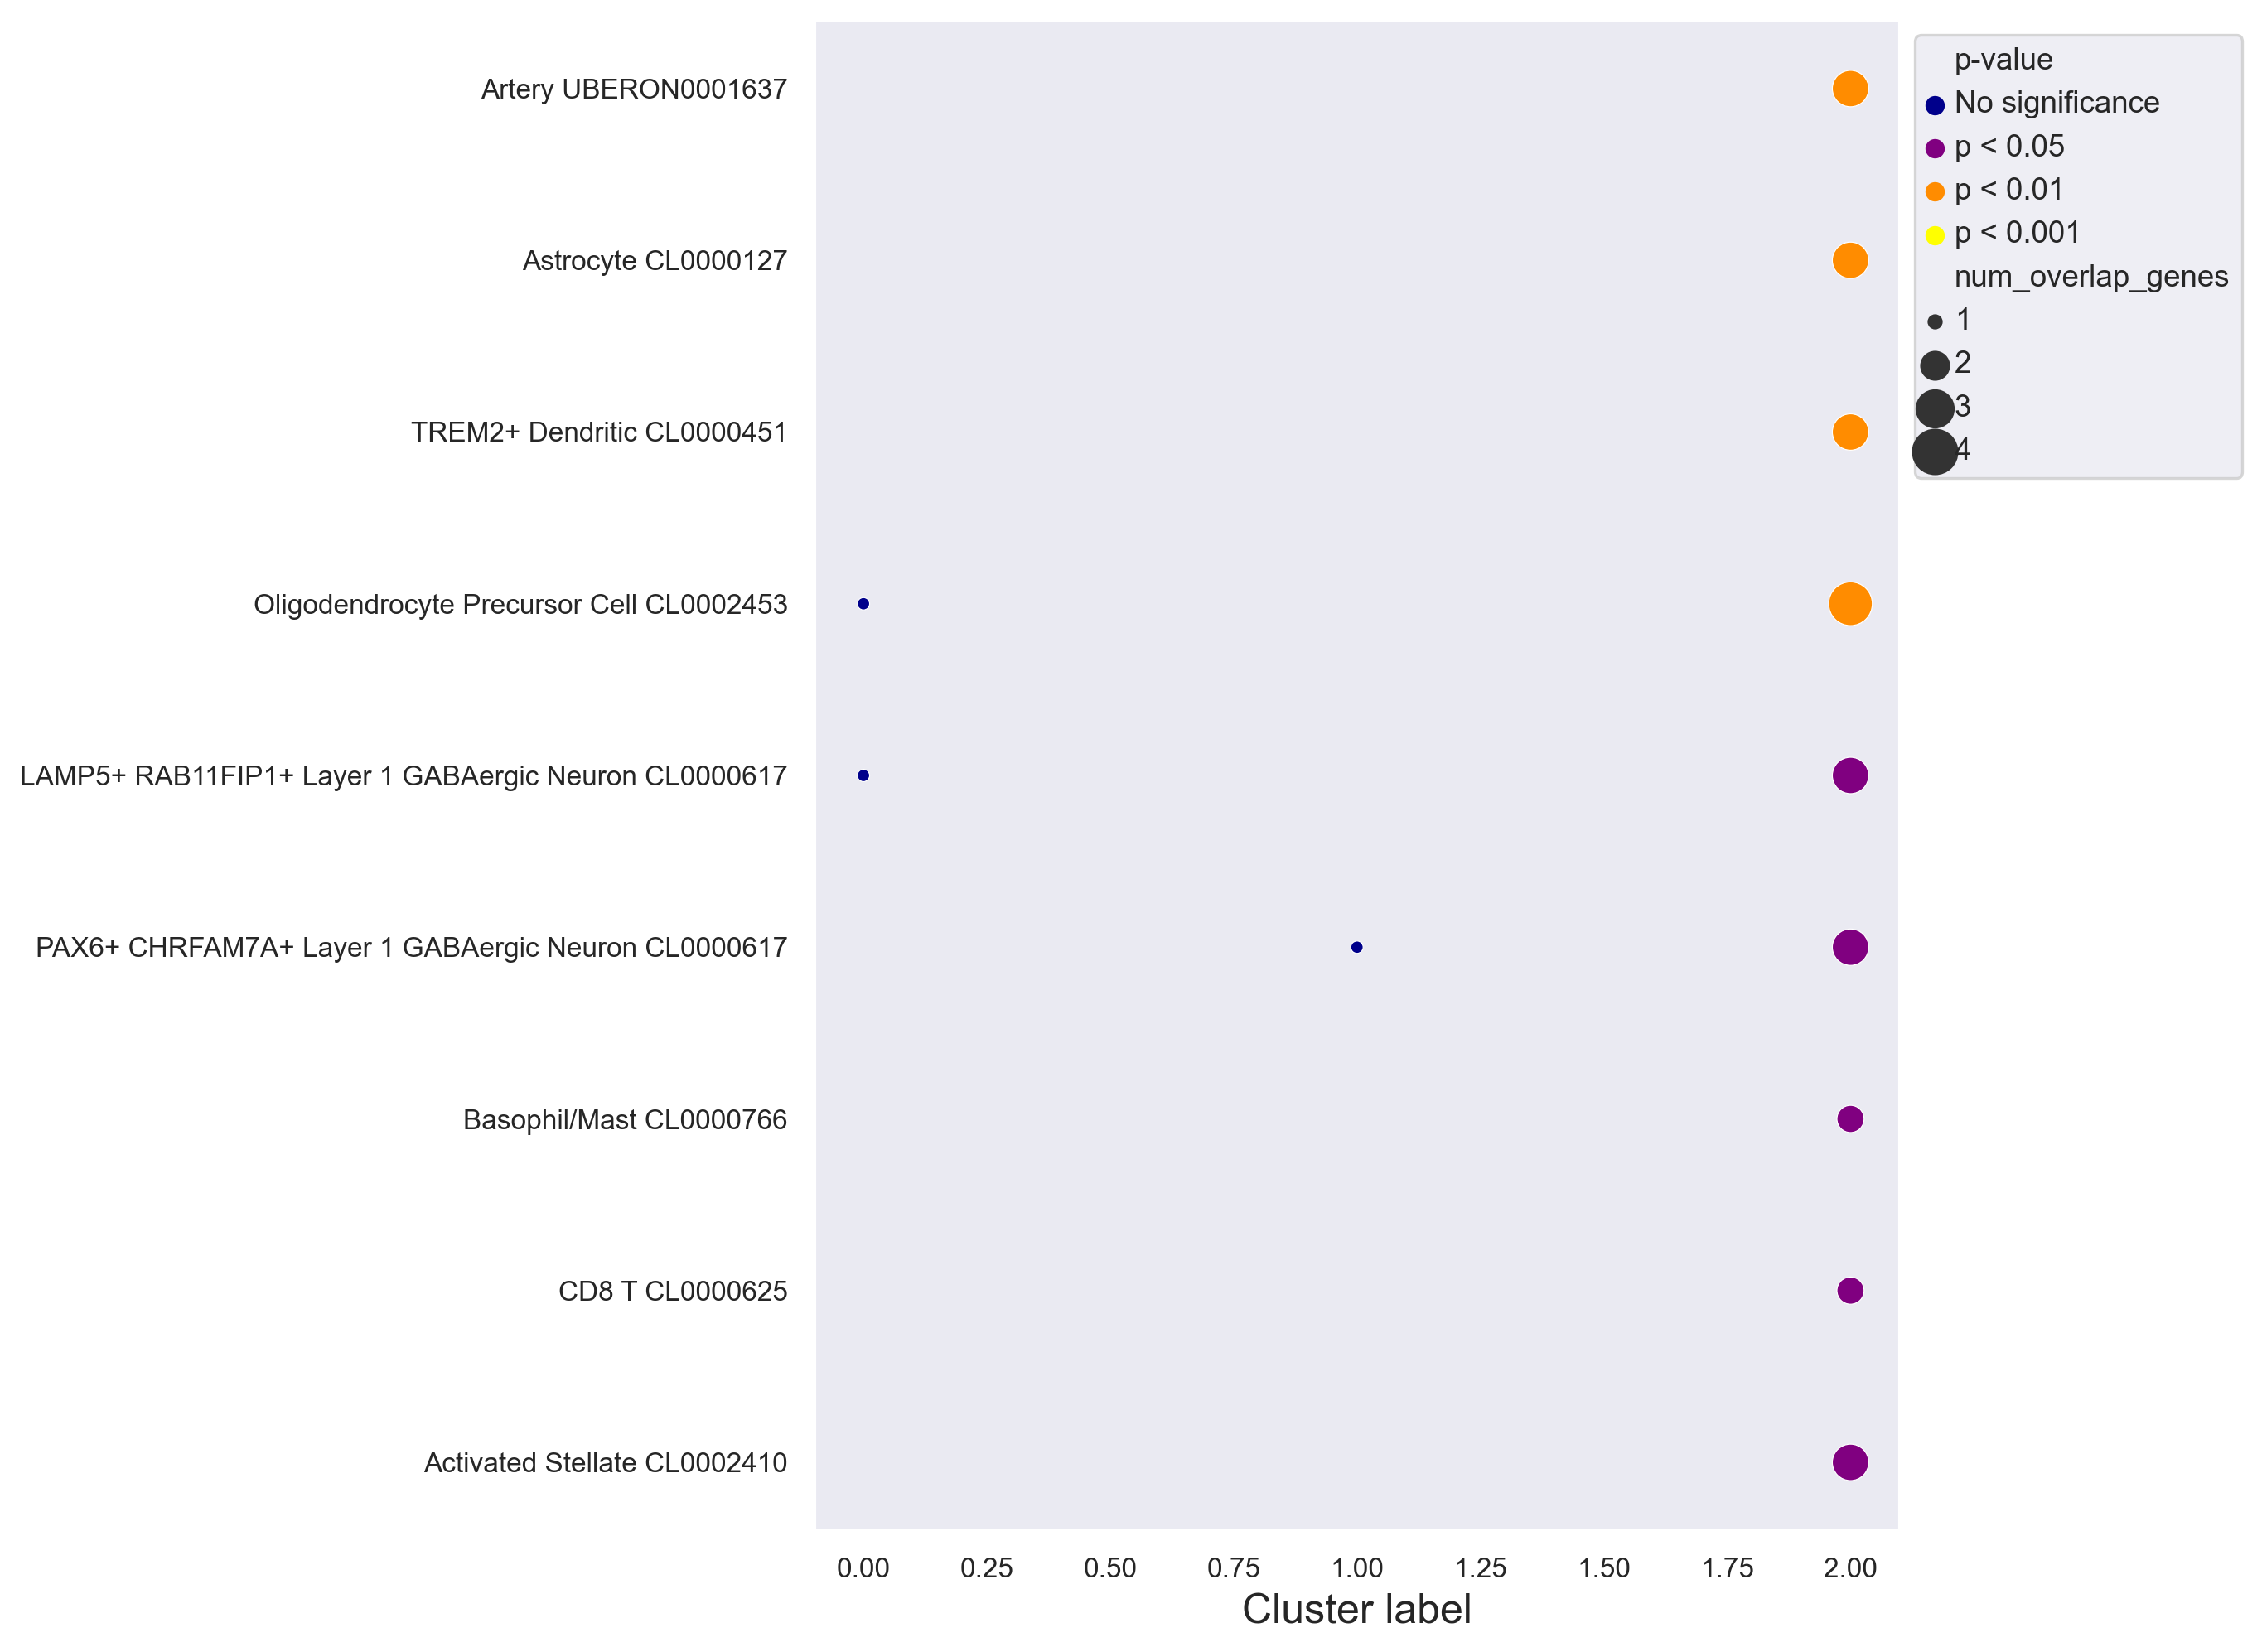

In [40]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [41]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [42]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
decreased susceptibility to dopaminergic neuron neurotoxicity MP:0011452,1,0.000134,23.487789,209.506610,"[GPR37, SPP1, SNCG, SNCA]",0.107833,0,0,4,0.967249,0
abnormal substantia nigra morphology MP:0000836,2,0.000143,87.828947,777.394913,"[NR4A2, GPR37, SPP1]",0.107833,0,0,3,0.967249,0
abnormal sensory neuron innervation pattern MP:0000968,3,0.000325,7.694352,61.805061,"[NELL2, NPPC, TENM3, SEMA3A, ETV1, NRG1]",0.163013,0,0,6,0.787777,0
abnormal innervation MP:0002184,4,0.000799,6.316801,45.051441,"[NELL2, MYCBP2, TBR1, NPTX1, NPTX2, CDK5R1]",0.300868,0,0,6,0.521624,0
increased circulating triiodothyronine level MP:0005480,5,0.001163,21.949836,148.318696,"[THRA, GPD2, CPE]",0.350151,0,0,3,0.455745,0


In [43]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

4

In [44]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

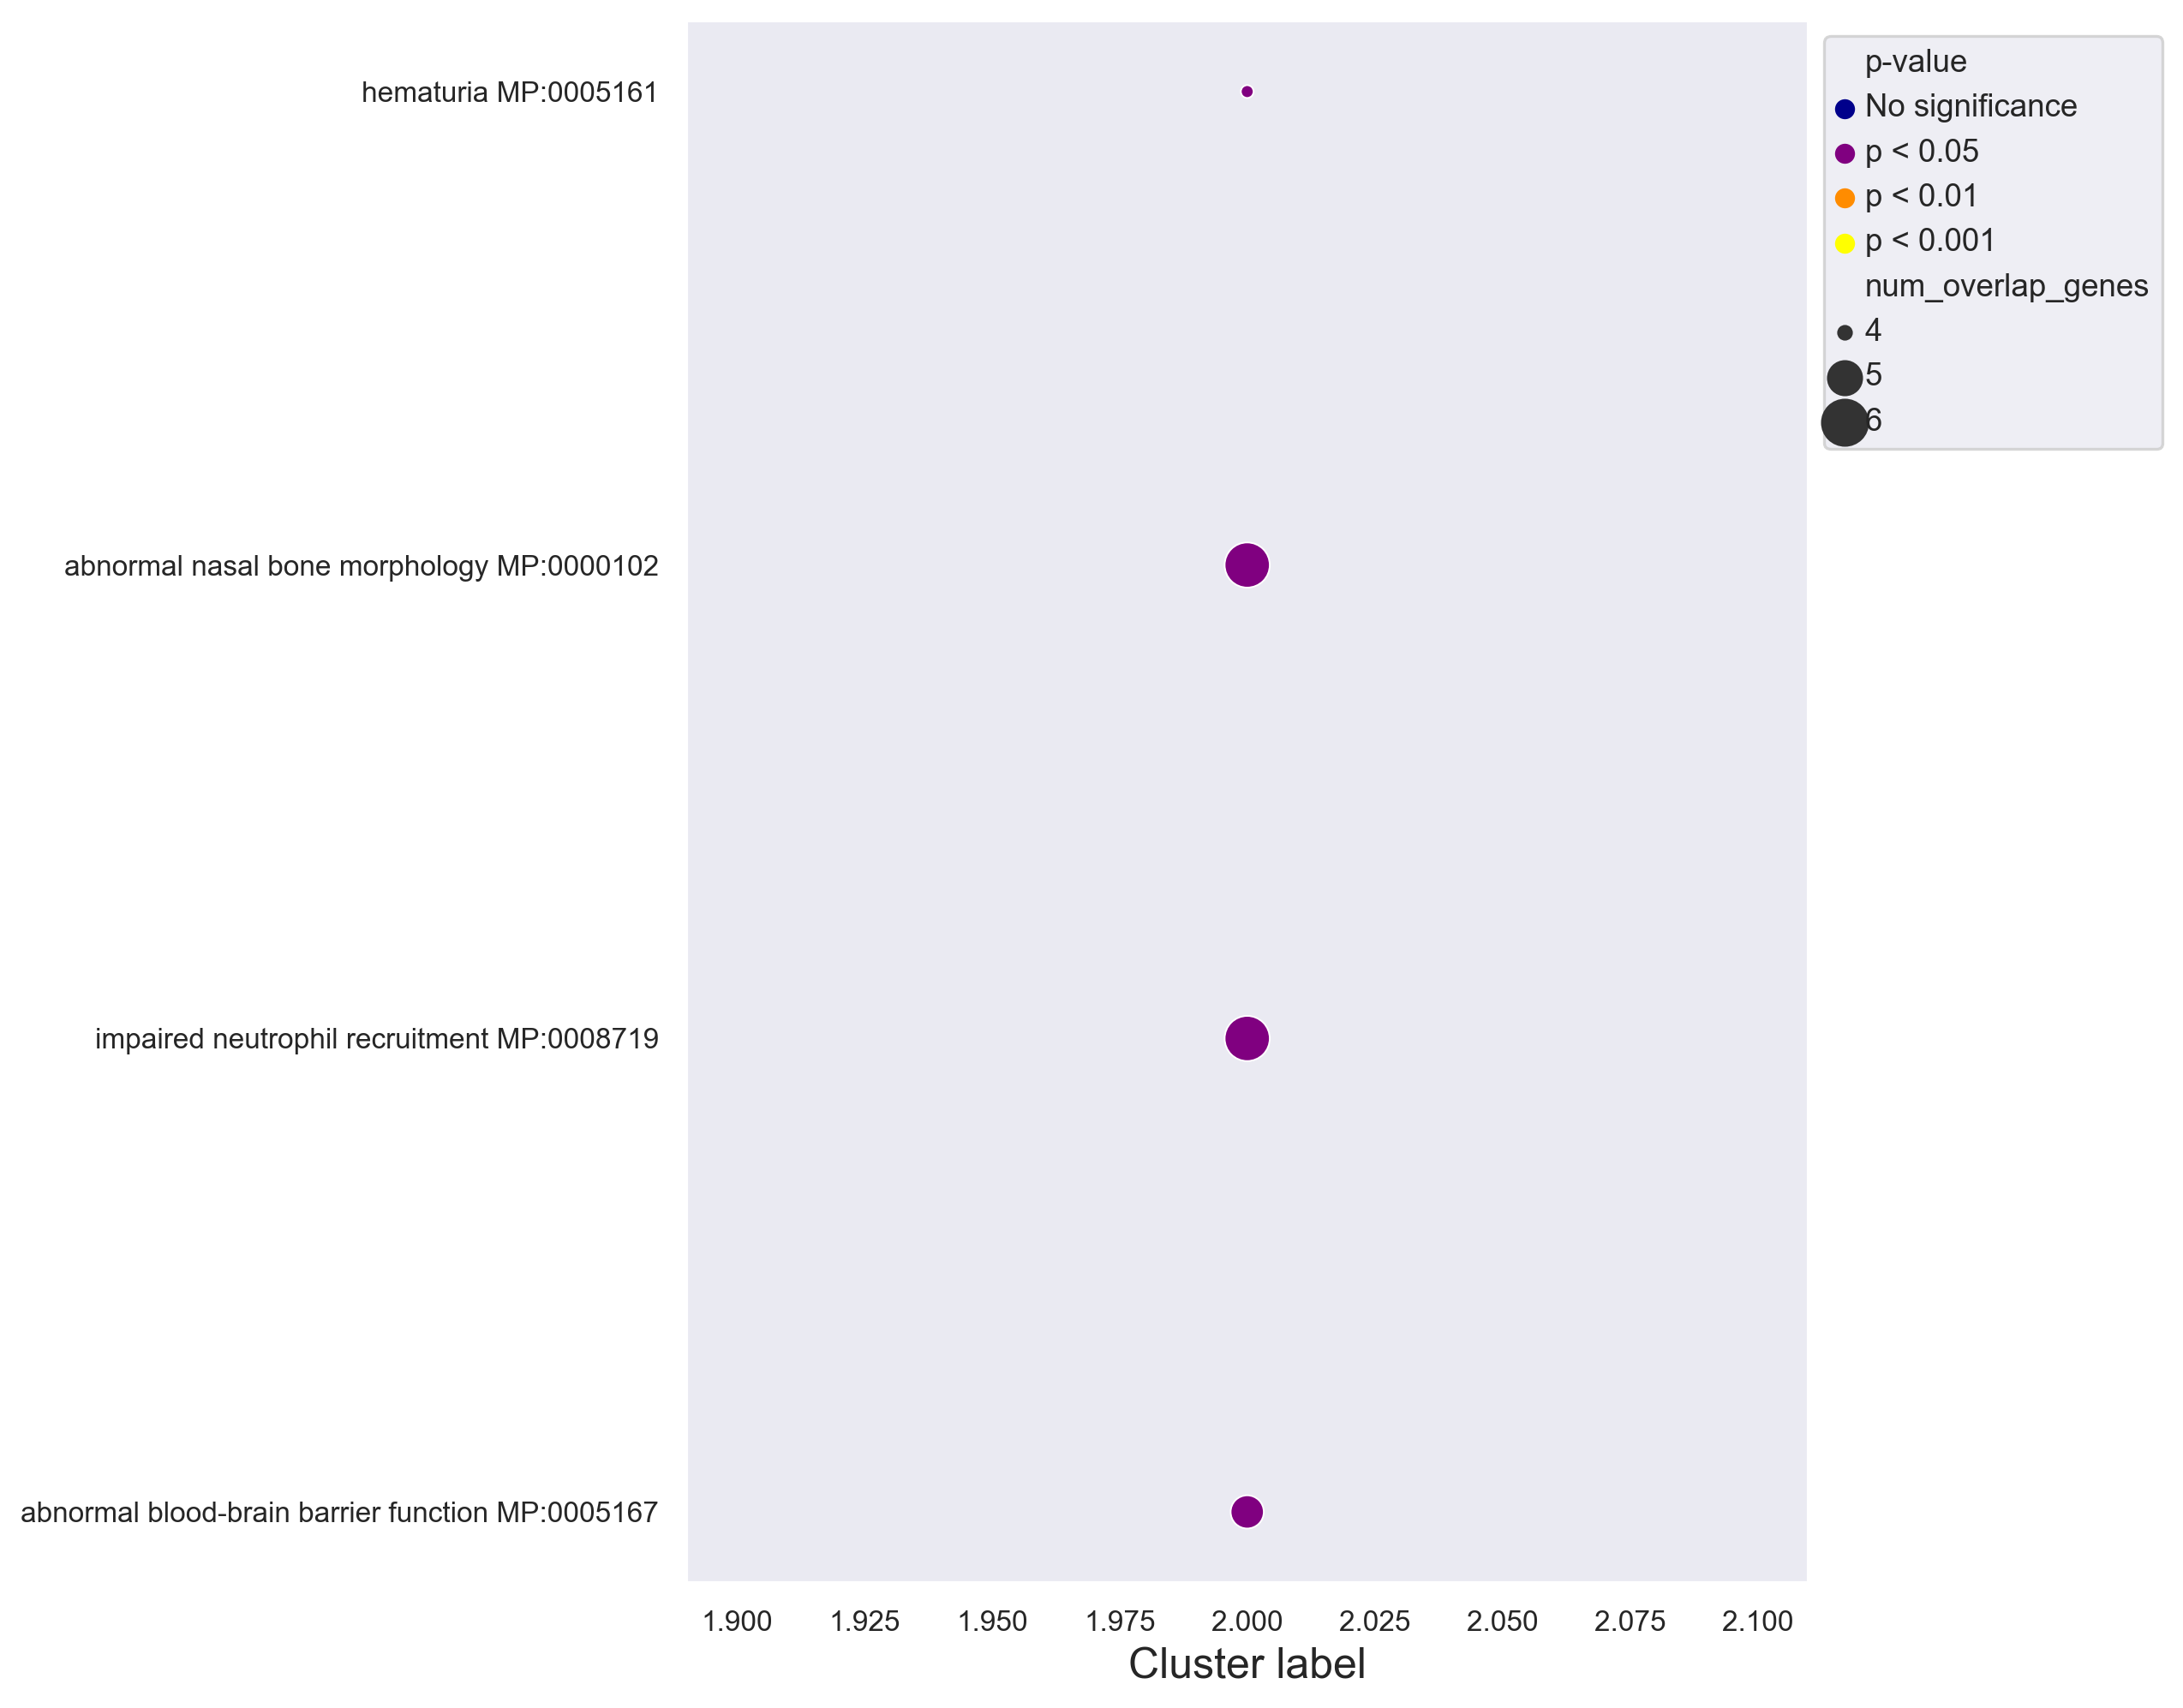

In [45]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [46]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [47]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Signaling By Receptor Tyrosine Kinases R-HSA-9006934,1,0.000575,2.290250,17.085961,"[CYFIP2, EGR1, GABRA1, MAP2K1, RBFOX2, ATP6AP1...",0.280909,0,0,23,0.551434,0
Activation Of Kainate Receptors Upon Glutamate Binding R-HSA-451326,2,0.000658,8.652123,63.389852,"[MPP3, GNB2, GRIK1, PLCB1, NCALD]",0.280909,0,0,5,0.551434,0
Neurotransmitter Receptors And Postsynaptic Signal Transmission R-HSA-112314,3,0.001216,3.053977,20.499655,"[PRKCG, GABRA1, MPP3, GRIN3A, GNB2, AP2S1, PRK...",0.346065,0,0,12,0.460842,0
Activation Of Ca-permeable Kainate Receptor R-HSA-451308,4,0.001814,17.557895,110.826777,"[MPP3, GRIK1, NCALD]",0.387345,0,0,3,0.411902,0
Transmission Across Chemical Synapses R-HSA-112315,5,0.002612,2.529817,15.046103,"[PRKCG, GABRA1, MPP3, SLC1A1, PRKAG2, GRIK1, N...",0.426262,0,0,14,0.370323,0


In [48]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [49]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

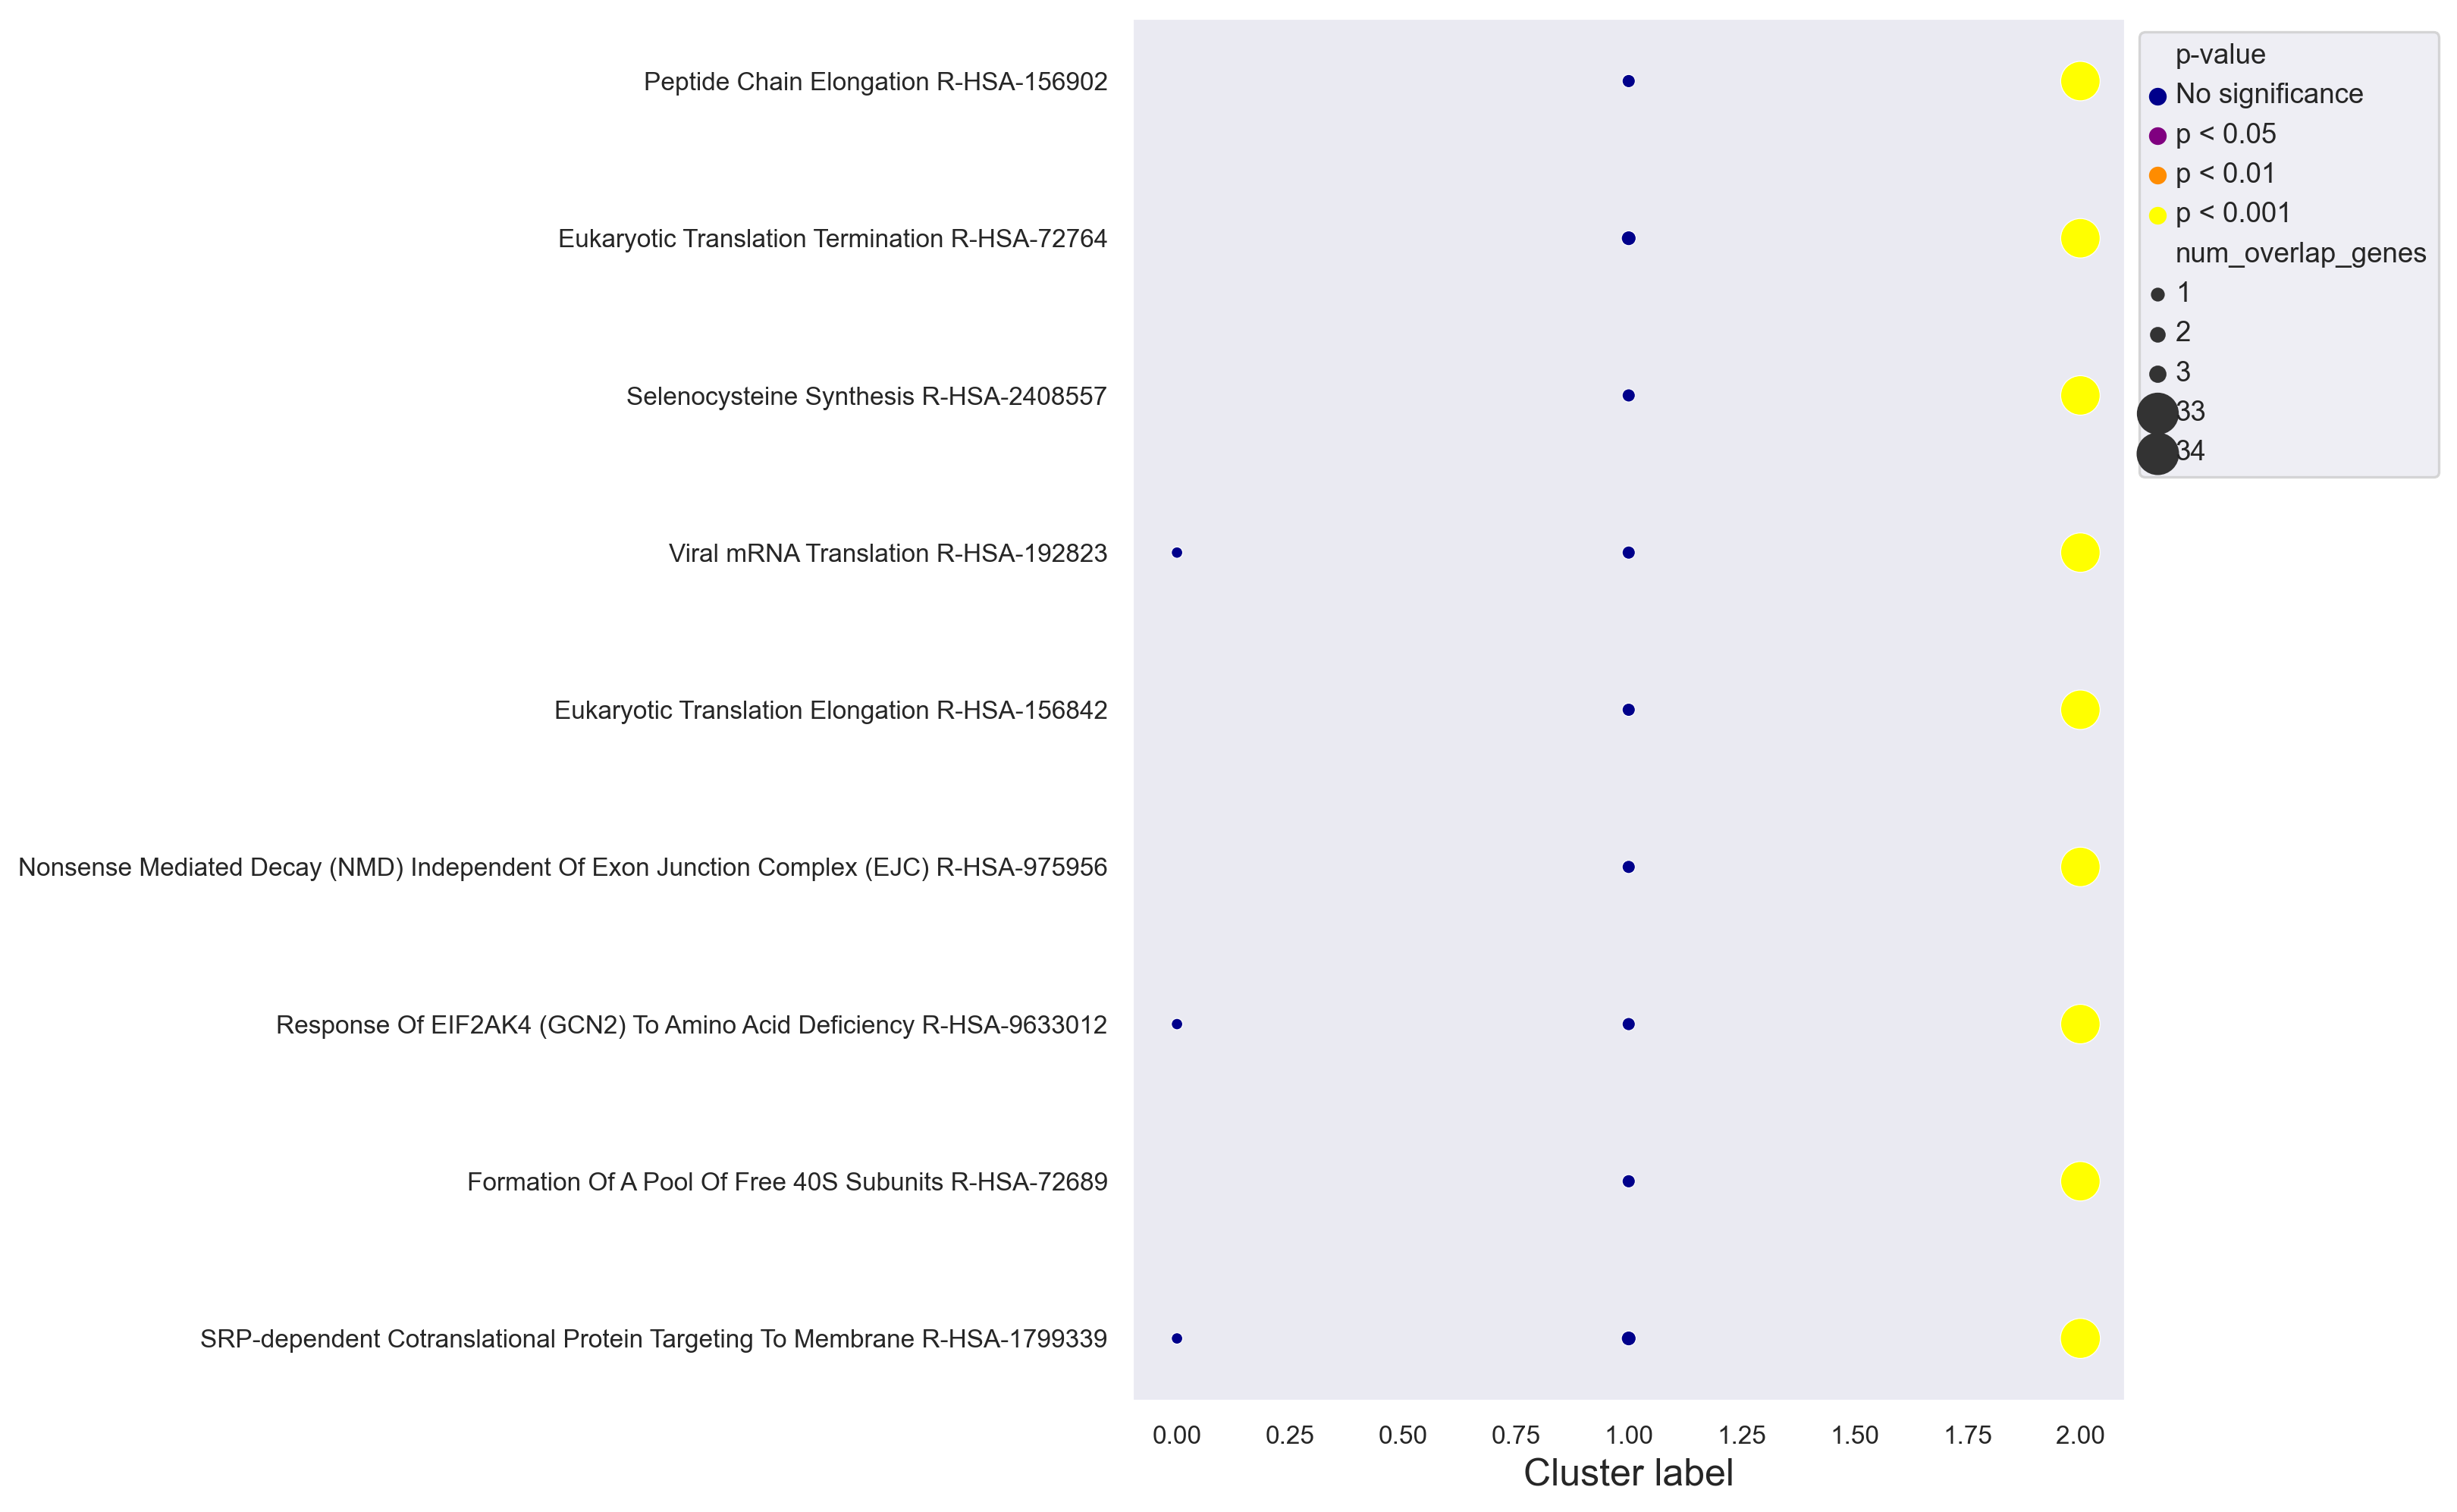

In [50]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [51]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [52]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Glycerophospholipid metabolism,1,0.000881,4.466713,31.420812,"[PTDSS1, GPD2, MBOAT7, MBOAT2, GPD1L, PNPLA6, ...",0.190299,0,0,8,0.720564,0
GnRH secretion,2,0.003561,4.529517,25.536501,"[PRKCG, CACNA1I, MAP2K1, SPP1, PIK3R1, PLCB1]",0.354706,0,0,6,0.450132,0
Oxidative phosphorylation,3,0.005840,3.191539,16.414378,"[ATP5PD, NDUFB10, ATP6AP1, SDHB, UQCRH, ATP5MC...",0.354706,0,0,8,0.450132,0
Vascular smooth muscle contraction,4,0.007270,3.381421,16.650267,"[PRKCG, ARHGEF11, NPPC, MAP2K1, MYL6, MYL6B, P...",0.354706,0,0,7,0.450132,0
Neuroactive ligand-receptor interaction,5,0.009479,2.913415,13.572590,"[GABRA1, GRIN3A, THRA, S1PR1, GRIK1, HTR2A, TA...",0.354706,0,0,8,0.450132,0


In [53]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

10

In [54]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

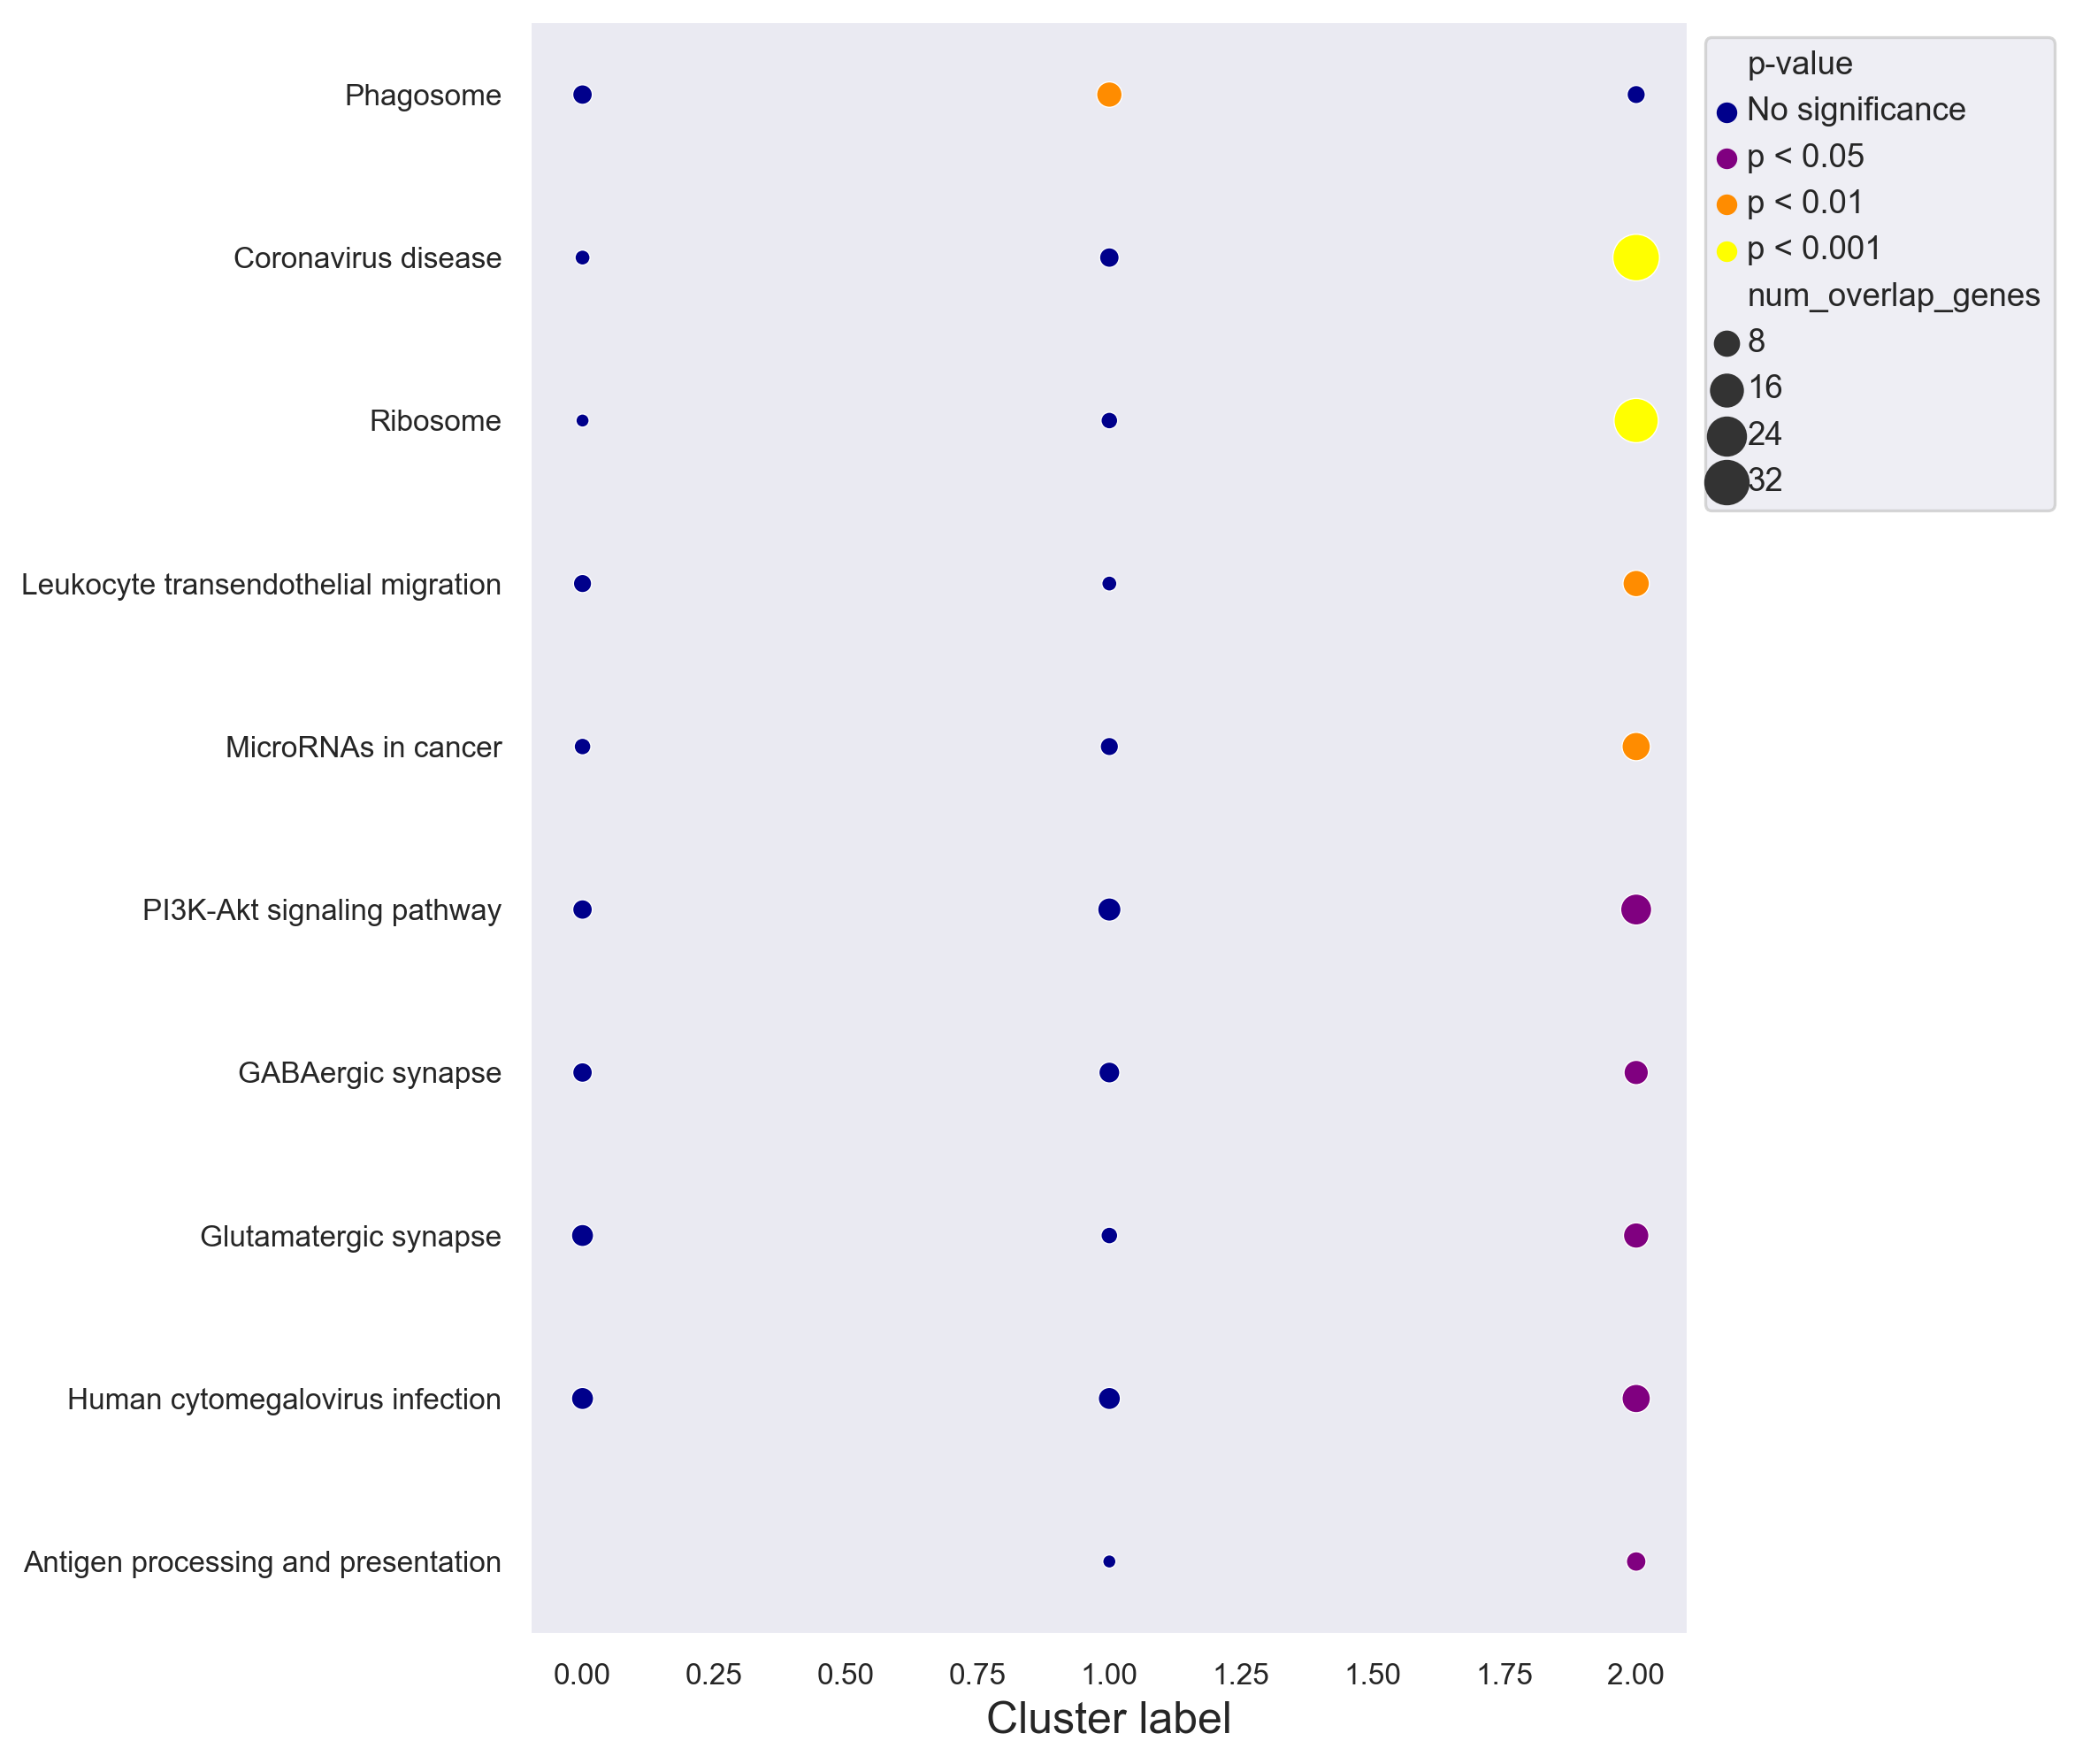

In [55]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))